In [12]:
%load_ext autoreload
%autoreload 2

import hydra
import os
import datetime
from pathlib import Path

# Initialize hydra and move to the root of the repository
try:
    hydra.initialize(version_base=None, config_path="../config/")
    CONFIG = hydra.compose(config_name="main.yaml")
    print('Initializing hydra')
except:
    print('Hydra already initalized!')
else:
    os.chdir('..')

# Create an output folder in the root of the repository
OUTPUT_FOLDER = Path('output/{0}'.format(datetime.datetime.now()))
Path(OUTPUT_FOLDER).mkdir(parents=True, exist_ok=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Hydra already initalized!


In [24]:
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
from src.utils.styling import hide_and_move_axis
import numpy as np

In [58]:
def weighted_network(edges):
    edge_weights = edges.groupby(['from', 'to']).Year.count().reset_index().rename(columns={'Year': 'weight'})
    edge_weights.weight /= edge_weights.weight.max()
    edge_weights = edge_weights.values.tolist()
    edge_weights = [[int(e[0]), int(e[1]), e[2]] for e in edge_weights]

    G = nx.Graph()
    G.add_weighted_edges_from(edge_weights)

    return G


def compute_communities(network, max_communities=10):

    comms = nx.community.louvain_communities(network)
    T = np.sort([len(c) for c in comms])[-max_communities]
    comms = [c for c in comms if len(c) >= T]
    assert len(comms) <= max_communities

    return comms


def draw_community_structure(network, position, communities):

    colors = get_standard_colors()

    f, ax = plt.subplots()

    nx.draw_networkx_nodes(network, position, node_size=12, node_color='k')
    nx.draw_networkx_edges(network, position, alpha=0.025)

    for i, comm in enumerate(communities):
        nx.draw_networkx_nodes(network, position, nodelist=comm, node_size=15, node_color=colors[i])

    plt.savefig(OUTPUT_FOLDER / 'communities.jpg')


def plot_edge_weight_distribution(network):

    weights = [network.get_edge_data(u, v)['weight'] for u, v in G.edges()]

    f, ax = plt.subplots()

    ax.hist(weights, bins=np.arange(0, 1, 0.05), width=0.04)
    ax.set_xlabel('Edge weight')
    ax.set_ylabel('Count')
    hide_and_move_axis(ax)

    plt.savefig(OUTPUT_FOLDER / 'edge_weight_histrogram.jpg')


def get_standard_colors():
    return plt.rcParams['axes.prop_cycle'].by_key()['color']


def plot_community_characteristics(edges, communities):

    fig, axarr = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(8, 4))
    flatax = axarr.flatten()
    colors = get_standard_colors()

    for i, community in enumerate(communities):

        in_edges = edges[edges['from'].isin(community) & edges['to'].isin(community)]
        ruling_parties = in_edges.PartyID.str[0]
        hist = ruling_parties.value_counts()

        hist = pd.DataFrame(hist)
        hist.sort_index(inplace=True)

        x, y = hist.index, hist['count'].values
        y = y / y.sum()

        flatax[i].bar(x, y, color=colors[i])
        hide_and_move_axis(flatax[i])

    axarr[1, 2].set_xlabel('Type of governing party')
    axarr[0, 0].set_ylabel('Relative frequency')
    axarr[1, 0].set_ylabel('Relative frequency')

    plt.savefig(OUTPUT_FOLDER / 'governing_parties.jpg')

In [49]:
NODES = pd.read_csv('data/01_raw/city_nodes_annual_all.csv')
EDGES = pd.read_csv('data/01_raw/city_edges_annual_all.csv')

POSITION = NODES[['PlaceID', 'XCOORD', 'YCOORD']].drop_duplicates().set_index('PlaceID').to_dict('index')
POSITION = {key: (value['XCOORD'], value['YCOORD']) for key, value in POSITION.items()}

In [53]:
NETWORK = weighted_network(edges=EDGES)
COMMUNITIES = compute_communities(NETWORK)

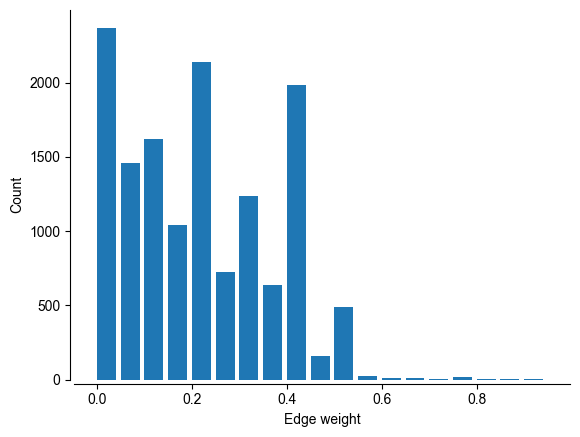

In [54]:
plot_edge_weight_distribution(network=NETWORK)

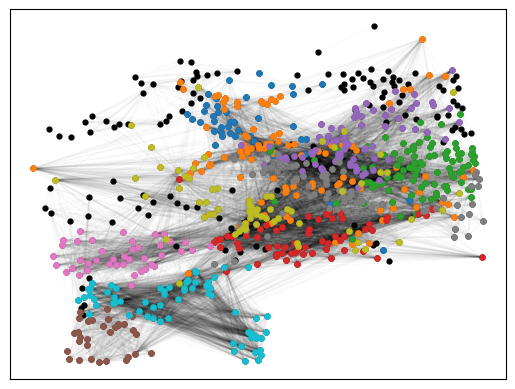

In [55]:
draw_community_structure(NETWORK, POSITION, COMMUNITIES)

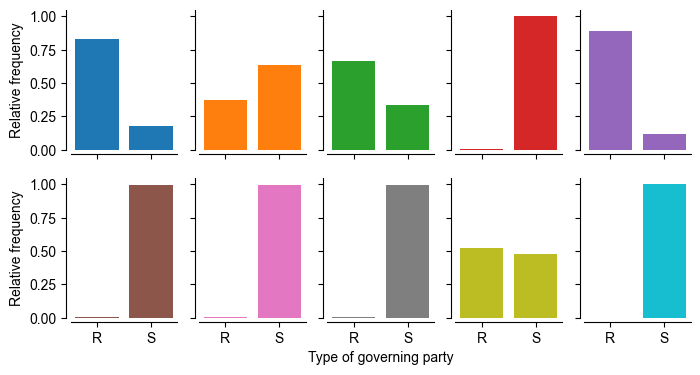

In [59]:
plot_community_characteristics(edges=EDGES, communities=COMMUNITIES)